In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.spatial import ConvexHull
from bellotti_r_master_thesis.plot_optimisation_results import draw_confidence_intervals

In [2]:
SEED = 4679903290

generator = np.random.Generator(np.random.PCG64(SEED))

# Config

In [3]:
optimisation_dir = '/data/user/bellotti_r/paper_new/optimisation/awa'

labels = [
    'random',
    'invertible'
]

nondominated_set_dirs = [
    f'{optimisation_dir}/forward_model/nondominated_set',
    f'{optimisation_dir}/invertible_model/nondominated_set',
]

In [4]:
plot_dir = f'../plots/optimisation/awa'

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [5]:
dpi = 300

In [6]:
dvar_labels = {
    'IBF': r'IBF [A]',
    'IM': r'IM [A]',
    'GPHASE': r'GPHASE [°]',
    'ILS1': 'ILS1 [A]',
    'ILS2': 'ILS2 [A]',
    'ILS3': 'ILS3 [A]',
    'bunchCharge': 'charge [nC]',
    'lambda': r'$\lambda$ [ps]',
    'SIGXY': r'SIGXY [mm]',
}

obj_labels = {
    'RMS Beamsize in x': r'$\sigma_x$ [mm]',
    'Normalized Emittance x': r'$\epsilon_x$ [mm mrad]',
    'energy spread of the beam': r'$\Delta E$ [keV]',
    'Correlation xpx': r'$\mathrm{Corr}(x, p_x)$'
}

In [7]:
dvar_cols = dvar_labels.keys()
objective_cols = ['RMS Beamsize in x', 'Normalized Emittance x', 'energy spread of the beam']

In [8]:
plot_all_generations = False

# Get list of available generations

In [9]:
# Example string: gen_100.hdf5
files = os.listdir(nondominated_set_dirs[0])
generations = [int(f.split('_')[1].split('.')[0]) for f in files]
generations = sorted(generations)

# Load the data

In [10]:
# non-dominated design variable configurations
dvars = []
# non-dominated objective values
objectives = []
# number of elements in the non-dominated set
n_nondominated = [{} for _ in range(len(labels))]

for i in range(len(labels)):
    for g in generations:
        file = f'{nondominated_set_dirs[i]}/gen_{g}.hdf5'
        
        dvar = pd.read_hdf(file, key='dvar').drop(columns='generation')
        obj = pd.read_hdf(file, key='obj')
        
        dvar.drop_duplicates(inplace=True)
        obj = obj.loc[dvar.index, :]
        
        dvar['optim'] = labels[i]
        obj['optim'] = labels[i]
        
        dvar['generation'] = g
        obj['generation'] = g
        
        assert dvar.shape[0] == obj.shape[0]
        n_nondominated[i][g] = dvar.shape[0]
        
        dvars.append(dvar)
        objectives.append(obj)

dvars = pd.concat(dvars, ignore_index=True)
objectives = pd.concat(objectives, ignore_index=True)

In [11]:
prediction_uncertainty_params = pd.read_csv('../plots/models/awa_forward_model/residual_parameters.tsv',
                                            sep='\t',
                                            index_col=0)

In [12]:
residual_quantiles = pd.read_csv('../plots/models/awa_forward_model/forward_prediction_residual_quantiles_by_longitudinal_pos.csv',
                                 index_col=(0, 1))
residual_quantiles = residual_quantiles.reset_index()
residual_quantiles = residual_quantiles.rename(columns={'level_1': 'quantile'})
residual_quantiles['Path length'] = np.round(residual_quantiles['Path length'], decimals=2)
residual_quantiles = residual_quantiles.query('`Path length` >= 25.95').reset_index(drop=True)
residual_quantiles.drop(columns='Path length', inplace=True)

In [13]:
opal_validation = []

for d in ['forward_model', 'invertible_model']:
    df = pd.read_hdf(f'{optimisation_dir}/{d}_validation/objectives.hdf5')
    df['optim'] = d
    opal_validation.append(df)

opal_validation = pd.concat(opal_validation, ignore_index=True)

opal_validation[['RMS Beamsize in x', 'RMS Beamsize in y']] *= 1000.
opal_validation[['Normalized Emittance x', 'Normalized Emittance y']] *= 1e6
opal_validation['energy spread of the beam'] *= 1000.

# Plots for paper

## Convergence

### Setup

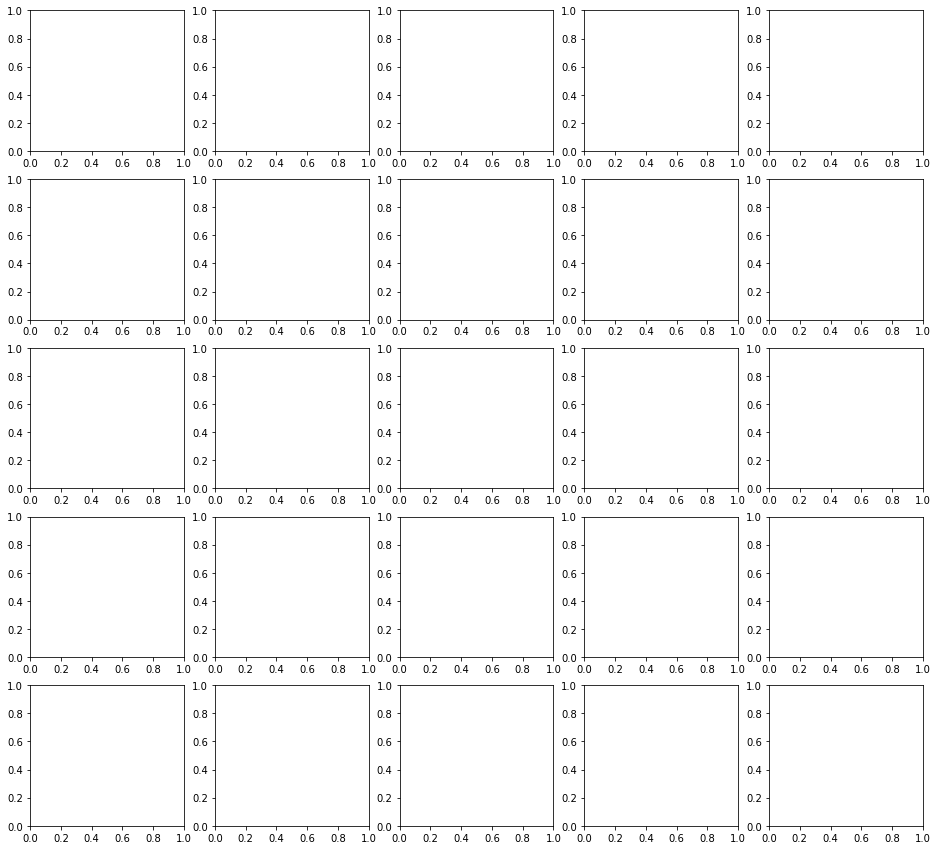

In [14]:
# styling
figsize=(16, 15)
axis_label_size = 25
axis_tick_size = 14
line_width = 2.5
annotation_size = 20
subplot_letter_size = 25
markersize = 2.
# figsize = (16, 9)
# axis_label_size = 16
# axis_tick_size = 10
# subplot_letter_size = 25

colors = sns.color_palette()

plot_confidence_intervals = True
generations_to_plot = [10, 15, 100, 200, 999]

# Create the figure.
fig, axes = plt.subplots(5, 5, figsize=figsize)

### Pairplots

In [15]:
blue = (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
orange = (1.0, 0.4980392156862745, 0.054901960784313725)

colormaps = [
    ListedColormap([
        (0, 0, 0, 0),
        (*blue, 0.2),
        (*blue, 0.4),
        (*blue, 0.6)
    ]),
    ListedColormap([
        (0, 0, 0, 0),
        (*orange, 0.2),
        (*orange, 0.4),
        (*orange, 0.6)
    ])
]

q = 0.9

obj_limits = {
    'RMS Beamsize in x': [0, 2],
    'Normalized Emittance x': [0, 10],
    'energy spread of the beam': [0, 400],
}

In [16]:
for i_gen, gen in enumerate(generations_to_plot):
    to_plot = objectives.query('`generation` == @gen')
    
    k = 1
    for i, y_col in enumerate(objective_cols):
        for j, x_col in enumerate(objective_cols):
            if j >= i:
                continue
            
            ax = axes[i_gen, k]

            df = to_plot.query('`optim` == "random"')
            dots = ax.plot(df[x_col],
                           df[y_col],
                           'o',
                           color=sns.color_palette()[0],
                           markersize=markersize)

            # need the case distinction to avoid weird plotting artifacts...
            # is there a bug when dots don't fit into the limits of the plot?
            if i_gen > 0:
                if plot_confidence_intervals:
                    draw_confidence_intervals(df[x_col].values,
                                              df[y_col].values,
                                              [q],
                                              [residual_quantiles.query('`quantile` == @q')[x_col].values],
                                              [residual_quantiles.query('`quantile` == @q')[y_col].values],
                                              obj_limits[x_col],
                                              obj_limits[y_col],
                                              50,
                                              colormaps[0],
                                              ax)

            df = to_plot.query('`optim` == "invertible"')
            dots = ax.plot(df[x_col],
                           df[y_col],
                           'o',
                           color=sns.color_palette()[1],
                           markersize=markersize)

            if plot_confidence_intervals:
                draw_confidence_intervals(df[x_col].values,
                                          df[y_col].values,
                                          [0.9],
                                          [residual_quantiles.query('`quantile` == 0.9')[x_col].values],
                                          [residual_quantiles.query('`quantile` == 0.9')[y_col].values],
                                          obj_limits[x_col],
                                          obj_limits[y_col],
                                          50,
                                          colormaps[1],
                                          ax)

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            if i_gen == 4:
                ax.set_xlabel(obj_labels[x_col], fontsize=axis_label_size)
            ax.set_ylabel(obj_labels[y_col], fontsize=axis_label_size)
            
            ax.tick_params(labelsize=axis_tick_size)
            
            ax.set_xlim(obj_limits[x_col])
            ax.set_ylim(obj_limits[y_col])
            
            k += 1

for i in range(len(generations_to_plot)):
    ax = axes[i, 0]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.text(
        x=0.5,
        y=0.5,
        s=f'Generation {generations_to_plot[i]}',
        fontsize=annotation_size,
        ha='center',
    )

### Convergence

In [17]:
obj_ranges = {col: (objectives[col].min(), objectives[col].max()) for col in objective_cols}

In [18]:
for i, col in enumerate(objective_cols):
    ax = axes[i, -1]
    
    for i, label in enumerate(labels):
        values = objectives.query('`optim` == @label')
        minimum = values.groupby('generation').min()[col]
        maximum = values.groupby('generation').max()[col]

        ax.fill_between(x=minimum.index,
                        y1=minimum.values,
                        y2=maximum.values,
                        color=sns.color_palette()[i],
                        alpha=0.3)

    ax.set_ylim(obj_ranges[col])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel('Generation', fontsize=axis_label_size)
    ax.set_ylabel(obj_labels[col], fontsize=axis_label_size)
    ax.tick_params(labelsize=axis_tick_size)

### Convex hull volume

In [19]:
def sample_residuals(generator, params, N):
    '''
    Sample N configurations from the given parameters.
    
    Parameters
    ----------
    generator: numpy.random.Generator
        Used to generate the random numbers.
    params: pd.DataFrame
        Contains the row index values 'mean' and 'std'
        indicating the parameters of the normal distribution
        to sample from.
    N: int
        Number pf samples to generate.
    '''
    df = {}
    
    for col in params.columns:
        df[col] = generator.normal(loc=params.loc['mean', col],
                                   scale=params.loc['std', col],
                                   size=N)
    
    return pd.DataFrame(df)

In [20]:
def sample_volumes(prediction, params, N_tries):
    volumes = []
    for N in range(N_tries):
        residuals = sample_residuals(generator,
                                     params[objective_cols],
                                     prediction.shape[0])
#         residuals = np.zeros_like(prediction)
        sampled_configs = prediction + residuals
        sampled_configs.clip(lower=0., inplace=True)
        
        hull = ConvexHull(sampled_configs)
        volumes.append(hull.volume)
    return volumes

In [21]:
ax = axes[3, -1]

all_volume_samples = []
all_volume_means = []
all_volume_stds = []

for optim in labels:
    gen = []
    volume_samples = []
    volume_means = []
    volume_stds = []

    for g, df in objectives.query('`optim` == @optim').groupby('generation'):
        if g % 50 != 0:
            continue

        if df.shape[0] < 4:
            continue

        df = df[objective_cols]

        volumes = sample_volumes(df.reset_index(drop=True),
                                 prediction_uncertainty_params,
                                 100)
        volumes = [v / 1e4 for v in volumes]
        vol_mean = np.mean(volumes)
        vol_std = np.std(volumes)
        
        volume_samples.append(volumes)
        volume_means.append(vol_mean)
        volume_stds.append(vol_std)
        
        gen.append(g)

    #ax.errorbar(gen, volume_means, yerr=volume_stds, label=optim)
    volume_means = np.array(volume_means)
    volume_stds = np.array(volume_stds)
    ax.plot(gen, volume_means)
    ax.fill_between(gen, volume_means - volume_stds, volume_means + volume_stds, alpha=0.3)
    
    all_volume_samples.append(volume_samples)
    all_volume_means.append(volume_means)
    all_volume_stds.append(volume_stds)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Generation', fontsize=axis_label_size)
ax.set_ylabel(r'$V_{ch}$ [a. u.]', fontsize=axis_label_size)
ax.tick_params(labelsize=axis_tick_size)

ax.set_xlim([0, 1000])

# for i, label in enumerate(labels):
#     ax.text(x=1050,
#             y=all_volume_means[i][-1],
#             s=label,
#             va='center',
#             fontsize=20,
#             color=sns.color_palette()[i])
# ax.set_xlim([0, 1400])
# ax.set_xticks(ax.get_xticks()[:-2]);

(0.0, 1000.0)

### No. non-dominated solutions

In [22]:
ax = axes[4, -1]

for i, label in enumerate(labels):
    x = []
    y = []
    for gen, n in n_nondominated[i].items():
        if gen % 50 == 0:
            x.append(gen)
            y.append(n)
    ax.plot(x, y, '-o', label=label, color=colors[i])


# ax.text(x=400,
#         y=700,
#         s=labels[0],
#         fontsize=22,
#         color=sns.color_palette()[0])
# ax.text(x=900,
#         y=650,
#         s=labels[1],
#         fontsize=22,
#         color=sns.color_palette()[1])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Generation', fontsize=axis_label_size)
ax.set_ylabel('No. solutions', fontsize=axis_label_size)

ax.tick_params(labelsize=axis_tick_size)

ax.set_xlim([0, 1000])

(0.0, 1000.0)

### Add subplot letter

In [23]:
axes[0, 0].set_title('a',
                     fontdict={
                         'fontweight': 'bold',
                         'fontsize': subplot_letter_size,
                     },
                     loc='left',
                     pad=10)
for i, letter in enumerate(['b', 'c', 'd', 'e', 'f']):
    axes[i, -1].set_title(letter,
                          fontdict={
                              'fontweight': 'bold',
                              'fontsize': subplot_letter_size,
                          },
                          loc='left',
                          pad=10);

axes[0, -1].text(x=1000,
                 y=1.5,
                 s='Random',
                 ha='right',
                 color=colors[0],
                 size=annotation_size,
                 weight='bold')
axes[0, -1].text(x=1000,
                 y=1.2,
                 s='Invertible',
                 ha='right',
                 color=colors[1],
                 size=annotation_size,
                 weight='bold')

Text(1000, 1.2, 'Invertible')

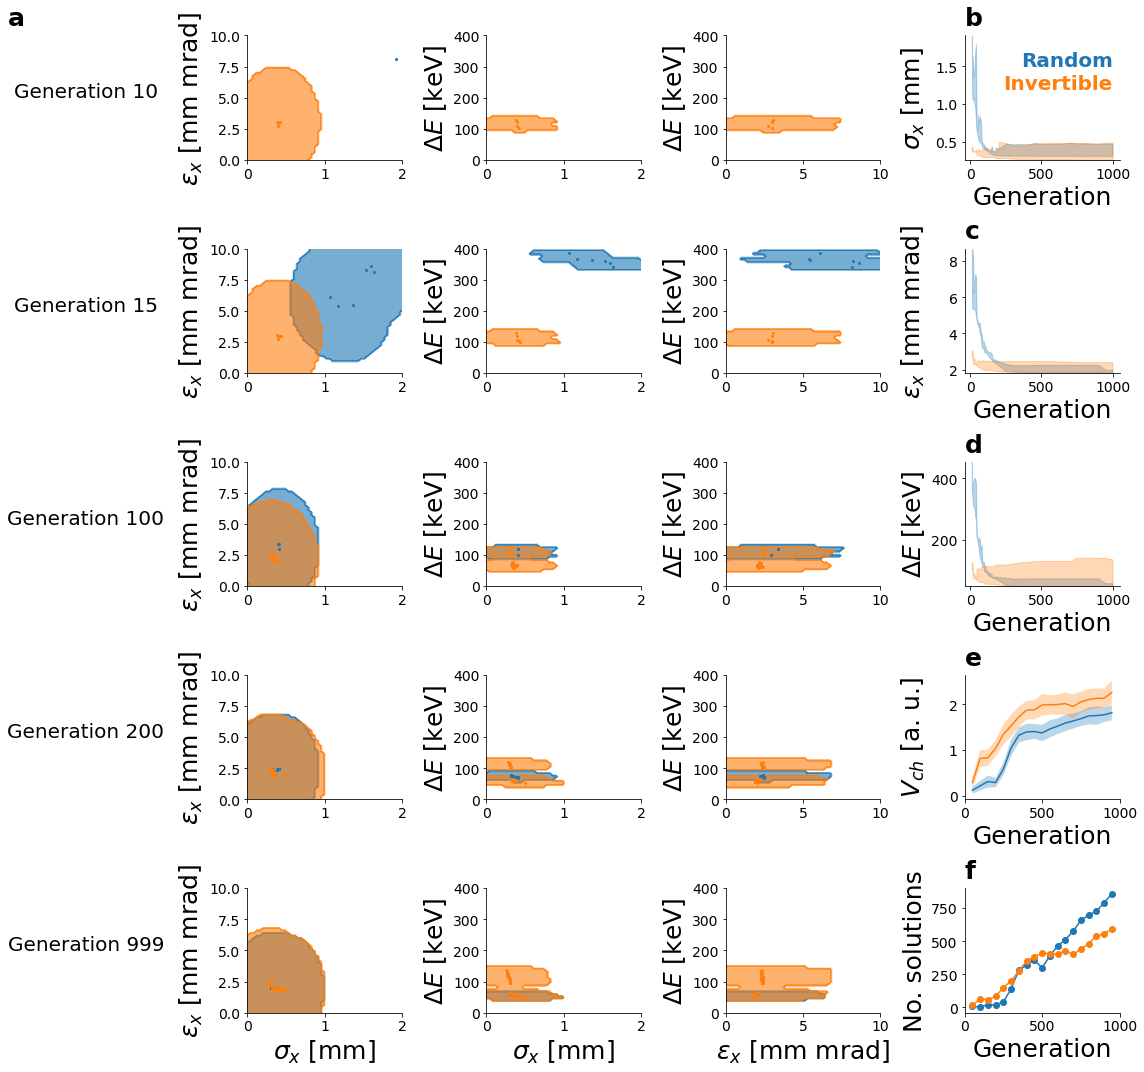

In [24]:
fig.align_labels()
fig.tight_layout()
fig.savefig(f'{plot_dir}/awa_optimisation.pdf', dpi=dpi)
fig

## Validation

### Setup

In [25]:
obj_limits = {
    'RMS Beamsize in x': [0., 1.1],
    'Normalized Emittance x': [0., 7.],
    'energy spread of the beam': [0., 160.],
}

In [26]:
# Create the figure.
fig = plt.Figure(figsize=(16, 9))
grid = fig.add_gridspec(2, 3)

### Objective space

In [27]:
k = 0

for i, y_col in enumerate(objective_cols):
    for j, x_col in enumerate(objective_cols):
        if j >= i:
            continue

        ax = fig.add_subplot(grid[0, k])

        df = opal_validation.query('`optim` == "forward_model"')
        dots = ax.plot(df[x_col],
                       df[y_col],
                       'o',
                       color=sns.color_palette()[0],
                       markersize=markersize)

        df = to_plot.query('`optim` == "random"')

        if plot_confidence_intervals:
            draw_confidence_intervals(df[x_col].values,
                                      df[y_col].values,
                                      [q],
                                      [residual_quantiles.query('`quantile` == @q')[x_col].values],
                                      [residual_quantiles.query('`quantile` == @q')[y_col].values],
                                      obj_limits[x_col],
                                      obj_limits[y_col],
                                      50,
                                      colormaps[0],
                                      ax)

        df = opal_validation.query('`optim` == "invertible_model"')
        dots = ax.plot(df[x_col],
                       df[y_col],
                       'o',
                       color=sns.color_palette()[1],
                       markersize=markersize)

        
        df = to_plot.query('`optim` == "invertible"')

        if plot_confidence_intervals:
            draw_confidence_intervals(df[x_col].values,
                                      df[y_col].values,
                                      [0.9],
                                      [residual_quantiles.query('`quantile` == 0.9')[x_col].values],
                                      [residual_quantiles.query('`quantile` == 0.9')[y_col].values],
                                      obj_limits[x_col],
                                      obj_limits[y_col],
                                      50,
                                      colormaps[1],
                                      ax)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.set_xlabel(obj_labels[x_col], fontsize=axis_label_size)
        ax.set_ylabel(obj_labels[y_col], fontsize=axis_label_size)

        ax.tick_params(labelsize=axis_tick_size)

        ax.set_xlim(obj_limits[x_col])
        ax.set_ylim(obj_limits[y_col])

        k += 1

In [28]:
xlim = [0.195, 0.25]
ylim = [-0.65, 0.35]

ax = fig.add_subplot(grid[1, :])

for i, optim in enumerate(['forward_model', 'invertible_model']):
    df = opal_validation.query('`optim` == @optim')
    
    ax.plot(df['RMS Beamsize in x'],
            df['Correlation xpx'],
            'o',
            markersize=markersize,
            color=colors[i])
    
    df = objectives.query(f'(`generation` == 999) & (`optim` == "{labels[i]}")')
    
    if plot_confidence_intervals:
        draw_confidence_intervals(df['RMS Beamsize in x'].values,
                                  df['Correlation xpx'].values,
                                  [0.9],
                                  [residual_quantiles.query('`quantile` == 0.9')['RMS Beamsize in x'].values],
                                  [residual_quantiles.query('`quantile` == 0.9')['Correlation xpx'].values],
                                  xlim,
                                  ylim,
                                  50,
                                  colormaps[i],
                                  ax)

# Plot feasible region.
ax.plot([0.1, 0.3], [0.1, 0.1], color='gray', linewidth=line_width)
ax.plot([0.1, 0.3], [-0.1, -0.1], color='gray', linewidth=line_width)

for coords in [(0.236, -0.08, 0., 0.18), (0.236, 0.08, 0., -0.18)]:
    ax.arrow(*coords,
             length_includes_head=True,
             head_length=0.03,
             head_width=0.0012,
             width=0.0002,
             color='gray',
             facecolor='gray',
             head_starts_at_zero=False)

ax.text(x=0.247,
        y=0.05,
        s='Allowed region',
        ha='right',
        va='center',
        fontsize=annotation_size,
        fontweight='bold',
        color='gray')

# Style plot.
ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(r'$\sigma_x$ [mm]', fontsize=axis_label_size)
ax.set_ylabel(r'$\mathrm{Corr}(x, p_x)$', fontsize=axis_label_size)
ax.tick_params(labelsize=axis_tick_size)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(x=0.247,
        y=0.2,
        s='Random',
        ha='right',
        fontsize=annotation_size,
        fontweight='bold',
        color=sns.color_palette()[0])
ax.text(x=0.247,
        y=0.13,
        s='Invertible',
        ha='right',
        fontsize=annotation_size,
        fontweight='bold',
        color=sns.color_palette()[1]);

/data/user/bellotti_r/turning_tables_env/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.


### Add subplot letter

In [29]:
for i, letter in enumerate(['a', 'b', 'c', 'd']):
    fig.get_axes()[i].set_title(letter,
                                fontdict={
                                    'fontweight': 'bold',
                                    'fontsize': subplot_letter_size,
                                },
                                loc='left',
                                pad=10)

/data/user/bellotti_r/turning_tables_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  


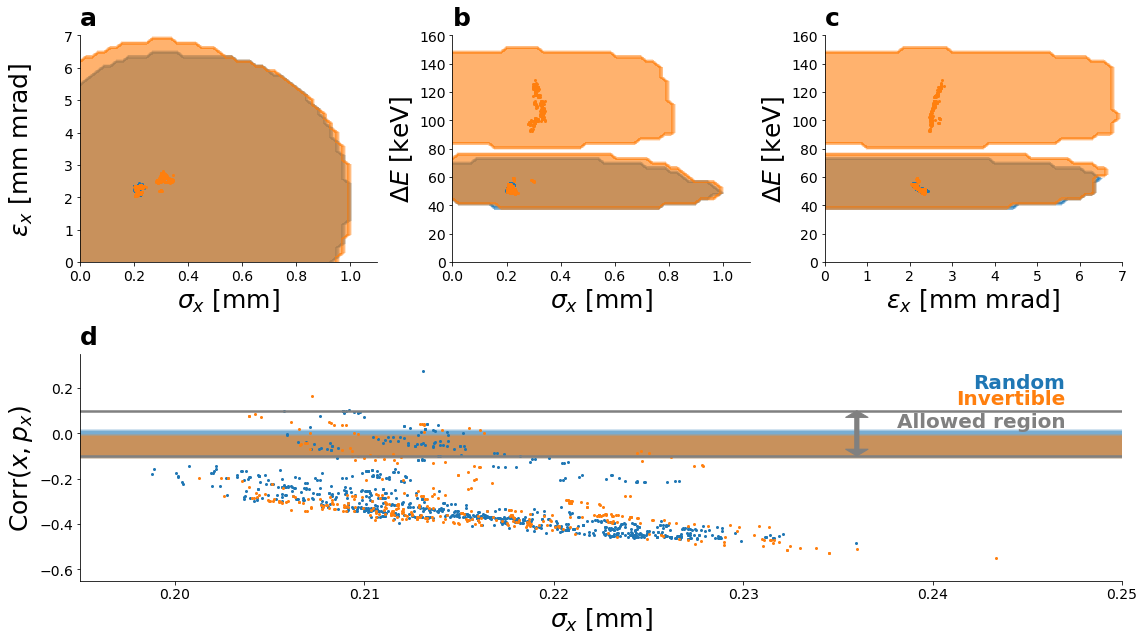

In [30]:
fig.align_labels()
fig.tight_layout()
fig.savefig(f'{plot_dir}/awa_optimisation_validation.pdf')
fig

# Plot

## Number of non-dominated solutions

The plot below shows for each generation $g$ how many non-dominated solutions have been found among the individuals in generation up to and including $g$.

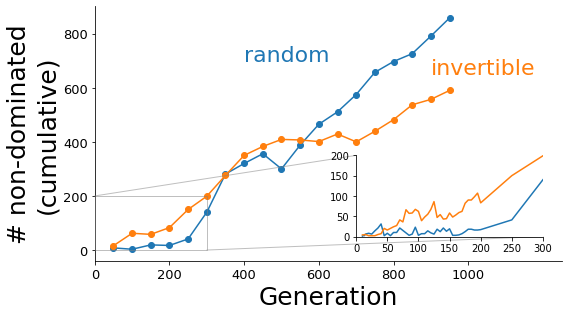

In [31]:
fig, ax = plt.subplots(figsize=(8, 4.5))

for i, label in enumerate(labels):
    x = []
    y = []
    for gen, n in n_nondominated[i].items():
        if gen % 50 == 0:
            x.append(gen)
            y.append(n)
    ax.plot(x, y, '-o', label=label)


ax.text(x=400,
        y=700,
        s=labels[0],
        fontsize=22,
        color=sns.color_palette()[0])
ax.text(x=900,
        y=650,
        s=labels[1],
        fontsize=22,
        color=sns.color_palette()[1])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Generation', fontsize=25)
ax.set_ylabel('# non-dominated\n(cumulative)', fontsize=25)

ax.set_xlim([0, 1250])
ax.set_xticks(ax.get_xticks()[:-2])

ax.tick_params(labelsize=13)


ax_inset = ax.inset_axes([700, 50, 500, 300], transform=ax.transData)

for i in range(len(labels)):
    x = []
    y = []
    for gen, n in n_nondominated[i].items():
        if gen <= 300:
            x.append(gen)
            y.append(n)
    
    ax_inset.plot(x, y)

ax_inset.set_xlim([0, 300])
ax_inset.set_ylim([0, 200])

ax_inset.spines['top'].set_visible(False)
ax_inset.spines['right'].set_visible(False)

ax.indicate_inset_zoom(ax_inset)

fig.tight_layout()
fig.savefig(f'{plot_dir}/number_of_nondom_solutions.jpg', dpi=dpi)

## Volume of the convex hull

<font color="red">Is this just an artifact of the prediction uncertainty???</font>

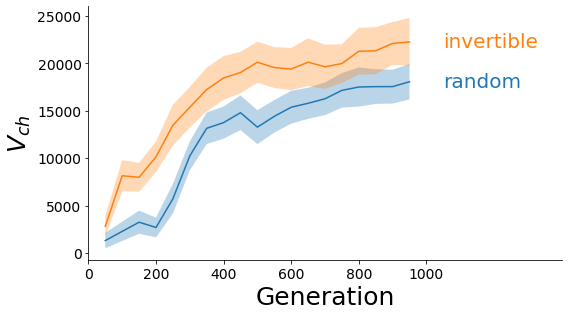

In [32]:
fig, ax = plt.subplots(figsize=(8, 4.5))

all_volume_samples = []
all_volume_means = []
all_volume_stds = []

for optim in labels:
    gen = []
    volume_samples = []
    volume_means = []
    volume_stds = []

    for g, df in objectives.query('`optim` == @optim').groupby('generation'):
        if g % 50 != 0:
            continue

        if df.shape[0] < 4:
            continue

        df = df[objective_cols]

        volumes = sample_volumes(df.reset_index(drop=True),
                                 prediction_uncertainty_params,
                                 100)
        vol_mean = np.mean(volumes)
        vol_std = np.std(volumes)
        
        volume_samples.append(volumes)
        volume_means.append(vol_mean)
        volume_stds.append(vol_std)
        
        gen.append(g)

    #ax.errorbar(gen, volume_means, yerr=volume_stds, label=optim)
    volume_means = np.array(volume_means)
    volume_stds = np.array(volume_stds)
    ax.plot(gen, volume_means)
    ax.fill_between(gen, volume_means - volume_stds, volume_means + volume_stds, alpha=0.3)
    
    all_volume_samples.append(volume_samples)
    all_volume_means.append(volume_means)
    all_volume_stds.append(volume_stds)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Generation', fontsize=25)
ax.set_ylabel('$V_{ch}$', fontsize=25)
ax.tick_params(labelsize=14)

for i, label in enumerate(labels):
    ax.text(x=1050,
            y=all_volume_means[i][-1],
            s=label,
            va='center',
            fontsize=20,
            color=sns.color_palette()[i])
ax.set_xlim([0, 1400])
ax.set_xticks(ax.get_xticks()[:-2]);

fig.tight_layout()
fig.savefig(f'{plot_dir}/volume_of_convex_hull_obj_space.jpg', dpi=dpi)

Calculate without uncertainty:

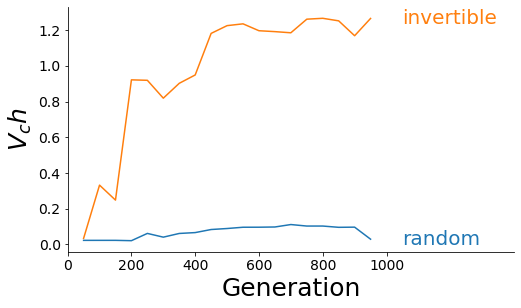

In [33]:
fig, ax = plt.subplots(figsize=(8, 4.5))

all_volumes = []

for optim in labels:
    gen = []
    volumes = []

    for g, df in objectives.query('`optim` == @optim').groupby('generation'):
        if g % 50 != 0:
            continue

        if df.shape[0] < 4:
            continue
        df = df[objective_cols]

        hull = ConvexHull(df)
        volumes.append(hull.volume)

        gen.append(g)

    ax.plot(gen, volumes, '-', label=optim)
    
    all_volumes.append(volumes)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel('Generation', fontsize=25)
ax.set_ylabel('$V_ch$', fontsize=25)
ax.tick_params(labelsize=14)

for i, label in enumerate(labels):
    ax.text(x=1050,
            y=all_volumes[i][-1],
            s=label,
            va='center',
            fontsize=20,
            color=sns.color_palette()[i])
ax.set_xlim([0, 1400])
ax.set_xticks(ax.get_xticks()[:-2]);

# fig.savefig(f'{plot_dir}/volume_of_convex_hull_obj_space.jpg', dpi=dpi)

## Non-dominated set ranges (objective space)

In [34]:
dvar_ranges = {
    'IBF': [450, 550],
    'IM': [100, 260],
    'GPHASE': [-50, 10],
    'ILS1': [0, 250],
    'ILS2': [0, 200],
    'ILS3': [0, 200],
    'bunchCharge': [0.3, 5.],
    'lambda': [0.3, 2.],
    'SIGXY': [1.5, 12.5],
}

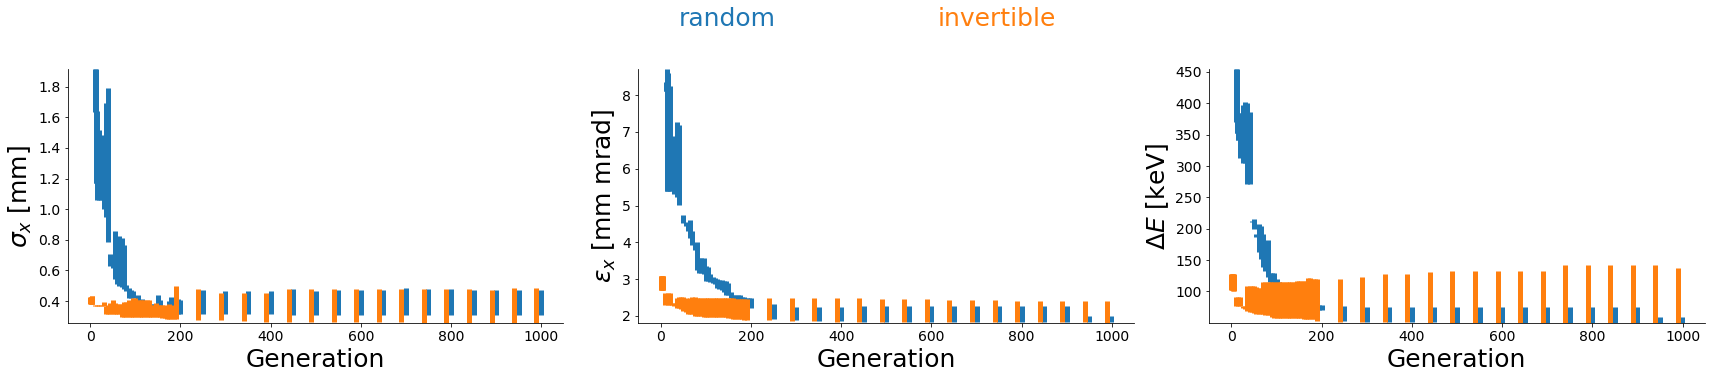

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(24, 4.5))

offset = 10

for i, col in enumerate(objective_cols):
    ax = axes[i]
    for gen in generations:
        for i, label in enumerate(labels):
            values = objectives.query('(`optim` == @label) & (`generation` == @gen)')[col]
            minimum = values.min()
            maximum = values.max()

            ax.vlines(x=gen + i * (-1) * offset,
                      ymin=minimum,
                      ymax=maximum,
                      linewidth=5,
                      color=sns.color_palette()[i])

    ax.set_ylim(obj_ranges[col])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel('Generation', fontsize=25)
    ax.set_ylabel(obj_labels[col], fontsize=25)
    ax.tick_params(labelsize=14)

fig.text(x=0.4, y=1.1, s=labels[0], fontsize=25, color=sns.color_palette()[0])
fig.text(x=0.55, y=1.1, s=labels[1], fontsize=25, color=sns.color_palette()[1])

fig.tight_layout()
#fig.savefig(f'{plot_dir}/objective_ranges.jpg', dpi=dpi)

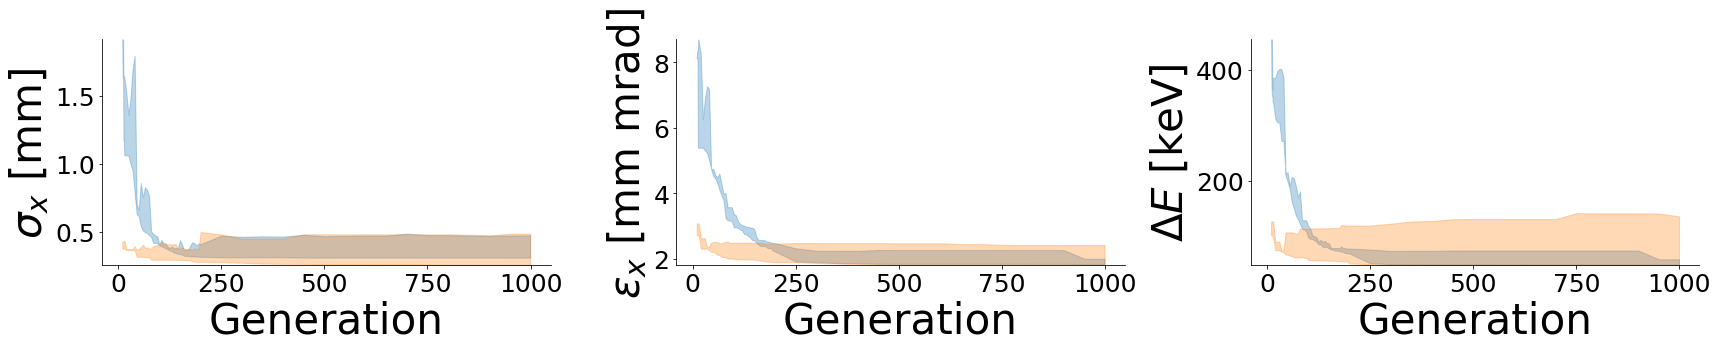

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(24, 4.5))

offset = 10

for i, col in enumerate(objective_cols):
    ax = axes[i]
    
    for i, label in enumerate(labels):
        values = objectives.query('`optim` == @label')
        minimum = values.groupby('generation').min()[col]
        maximum = values.groupby('generation').max()[col]

        ax.fill_between(x=minimum.index,
                        y1=minimum.values,
                        y2=maximum.values,
                        color=sns.color_palette()[i],
                        alpha=0.3)

    ax.set_ylim(obj_ranges[col])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_xlabel('Generation', fontsize=42)
    ax.set_ylabel(obj_labels[col], fontsize=42)
    ax.tick_params(labelsize=25)

#fig.text(x=0.4, y=1.1, s=labels[0], fontsize=45, color=sns.color_palette()[0])
#fig.text(x=0.55, y=1.1, s=labels[1], fontsize=45, color=sns.color_palette()[1])

fig.tight_layout()
fig.savefig(f'{plot_dir}/objective_ranges.jpg', dpi=dpi, bbox_inches='tight')

## Non-dominated set (objective space)

current_plot_dir = f'{plot_dir}/obj_over_generations'

if not os.path.exists(current_plot_dir):
    os.makedirs(current_plot_dir)

for gen, to_plot in objectives.groupby('generation'):
    fig, axes = plt.subplots(1, 3, figsize=(12, 4.5))
    
    k = 0
    for i, y_col in enumerate(objective_cols):
        for j, x_col in enumerate(objective_cols):
            if j >= i:
                continue
            
            ax = axes[k]

            df = to_plot.query('`optim` == "random"')
            dots = ax.plot(df[x_col],
                           df[y_col],
                           'o',
                           color=sns.color_palette()[0],
                           markersize=1)
            
            df = to_plot.query('`optim` == "invertible"')
            dots = ax.plot(df[x_col],
                           df[y_col],
                           'o',
                           color=sns.color_palette()[1],
                           markersize=1)

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            ax.set_xlabel(obj_labels[x_col], fontsize=20)
            ax.set_ylabel(obj_labels[y_col], fontsize=20)
            
            ax.tick_params(labelsize=14)
            
            ax.set_xlim(obj_ranges[x_col])
            ax.set_ylim(obj_ranges[y_col])
            
            k += 1

    fig.text(x=0.55,
             y=0.9,
             s=f'Generation {gen}',
             ha='center',
             fontsize=18)
    fig.tight_layout()
    fig.align_labels()
    
    fig.savefig(f'{current_plot_dir}/gen_{gen}.jpg', dpi=dpi)

In [37]:
if plot_all_generations:
    current_plot_dir = f'{plot_dir}/obj_over_generations'

    if not os.path.exists(current_plot_dir):
        os.makedirs(current_plot_dir)

    for gen, to_plot in objectives.groupby('generation'):
        fig, axes = plt.subplots(2, 3, figsize=(12, 7))

        k = 0
        for i, y_col in enumerate(objective_cols):
            for j, x_col in enumerate(objective_cols):
                if j >= i:
                    continue

                ax = axes[0, k]

                df = to_plot.query('`optim` == "random"')
                dots = ax.plot(df[x_col],
                               df[y_col],
                               'o',
                               color=sns.color_palette()[0],
                               markersize=1)

                df = to_plot.query('`optim` == "invertible"')
                dots = ax.plot(df[x_col],
                               df[y_col],
                               'o',
                               color=sns.color_palette()[1],
                               markersize=1)

                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)

                ax.set_xlabel(obj_labels[x_col], fontsize=20)
                ax.set_ylabel(obj_labels[y_col], fontsize=20)

                ax.tick_params(labelsize=14)

                ax.set_xlim(obj_ranges[x_col])
                ax.set_ylim(obj_ranges[y_col])

                k += 1

        # plot number of solutions
        gs = axes[1, 0].get_gridspec()
        for ax in axes[1, :]:
            ax.remove()
        ax = fig.add_subplot(gs[1, :])

        for which in range(len(labels)):
            x = [g for g in n_nondominated[which].keys() if g <= gen]
            y = [n_nondominated[which][g] for g in x]
            ax.plot(x, y, '-o', color=sns.color_palette()[which])

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.set_xlabel('Generation', fontsize=20)
        ax.set_ylabel('# Non-dom. solutions', fontsize=20)

        ax.set_xlim((min(generations), max(generations)))
        ax.set_ylim((0, max([*list(n_nondominated[0].values()), *list(n_nondominated[1].values())])))

        # label the generation
        fig.text(x=0.5,
                 y=0.9,
                 s=f'Generation {gen}',
                 ha='center',
                 fontsize=18)
        fig.tight_layout()
        fig.align_labels()

        fig.savefig(f'{current_plot_dir}/gen_{gen}.jpg', dpi=dpi)

## Non-dominated set (design space)

In [38]:
if plot_all_generations:
    current_plot_dir = f'{plot_dir}/obj_over_generations'

    if not os.path.exists(current_plot_dir):
        os.makedirs(current_plot_dir)

    for gen, to_plot in objectives.groupby('generation'):
        fig, axes = plt.subplots(1, 3, figsize=(12, 4.5))

        k = 0
        for i, y_col in enumerate(objective_cols):
            for j, x_col in enumerate(objective_cols):
                if j >= i:
                    continue

                ax = axes[k]

                df = to_plot.query('`optim` == "random"')
                dots = ax.plot(df[x_col],
                               df[y_col],
                               'o',
                               color=sns.color_palette()[0],
                               markersize=1.5)

                df = to_plot.query('`optim` == "invertible"')
                dots = ax.plot(df[x_col],
                               df[y_col],
                               'o',
                               color=sns.color_palette()[1],
                               markersize=1.5)

                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)

                ax.set_xlabel(obj_labels[x_col], fontsize=20)
                ax.set_ylabel(obj_labels[y_col], fontsize=20)

                ax.tick_params(labelsize=14)

                ax.set_xlim(obj_ranges[x_col])
                ax.set_ylim(obj_ranges[y_col])

                k += 1

        fig.text(x=0.55,
                 y=0.9,
                 s=f'Generation {gen}',
                 ha='center',
                 fontsize=18)
        fig.tight_layout()
        fig.align_labels()

        fig.savefig(f'{current_plot_dir}/gen_{gen}.jpg', dpi=dpi)

current_plot_dir = f'{plot_dir}/dvar_over_generations'

if not os.path.exists(current_plot_dir):
    os.makedirs(current_plot_dir)

for gen, to_plot in dvars.groupby('generation'):
    fig, axes = plt.subplots(len(dvar_cols), len(dvar_cols), figsize=(24, 13.5))
    
    for i, y_col in enumerate(dvar_cols):
        for j, x_col in enumerate(dvar_cols):
            if j >= i:
                axes[i, j].remove()
                continue
            
            ax = axes[i, j]

            df = to_plot.query('`optim` == "random"')
            dots = ax.plot(df[x_col], df[y_col], 'o', color=sns.color_palette()[0])
            
            df = to_plot.query('`optim` == "invertible"')
            dots = ax.plot(df[x_col], df[y_col], 'o', color=sns.color_palette()[1])

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            if i == len(dvar_cols) - 1:
                ax.set_xlabel(dvar_labels[x_col])
            if j == 0:
                ax.set_ylabel(dvar_labels[y_col])
            
            ax.set_xlim(dvar_ranges[x_col])
            ax.set_ylim(dvar_ranges[y_col])

    fig.text(x=0.6,
             y=0.6,
             s=f'Generation {gen}',
             fontsize=35)
    fig.tight_layout()
    fig.align_labels()
    
    fig.savefig(f'{current_plot_dir}/gen_{gen}.jpg', dpi=dpi)

## Non-dominated set (objective space) in 3D

<font color="red">TODO?</font>

## Non-dominated sets comparison

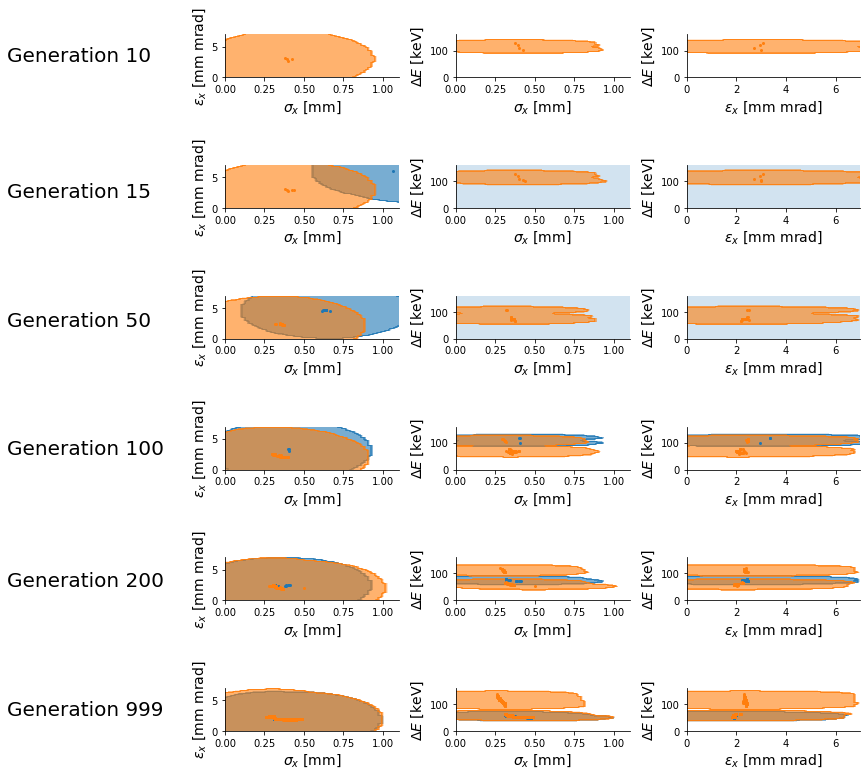

In [39]:
fig, axes = plt.subplots(6, 3, figsize=(12, 10.5))

generations_to_plot = [10, 15, 50, 100, 200, 999]

markersize = 2.

for i_gen, gen in enumerate(generations_to_plot):
    to_plot = objectives.query('`generation` == @gen')
    
    k = 0
    for i, y_col in enumerate(objective_cols):
        for j, x_col in enumerate(objective_cols):
            if j >= i:
                continue
            
            ax = axes[i_gen, k]

            df = to_plot.query('`optim` == "random"')
            dots = ax.plot(df[x_col],
                           df[y_col],
                           'o',
                           color=sns.color_palette()[0],
                           markersize=markersize)
            
            if i_gen > 0:
                # need the case distinction to avoid weird plotting artifacts...
                # is there a bug when dots don't fit into the limits of the plot?
                draw_confidence_intervals(df[x_col].values,
                                          df[y_col].values,
                                          [q],
                                          [residual_quantiles.query('`quantile` == @q')[x_col].values],
                                          [residual_quantiles.query('`quantile` == @q')[y_col].values],
                                          obj_limits[x_col],
                                          obj_limits[y_col],
                                          50,
                                          colormaps[0],
                                          ax)
            
            df = to_plot.query('`optim` == "invertible"')
            dots = ax.plot(df[x_col],
                           df[y_col],
                           'o',
                           color=sns.color_palette()[1],
                           markersize=markersize)
            
            draw_confidence_intervals(df[x_col].values,
                                      df[y_col].values,
                                      [0.9],
                                      [residual_quantiles.query('`quantile` == 0.9')[x_col].values],
                                      [residual_quantiles.query('`quantile` == 0.9')[y_col].values],
                                      obj_limits[x_col],
                                      obj_limits[y_col],
                                      50,
                                      colormaps[1],
                                      ax)

            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)

            ax.set_xlabel(obj_labels[x_col], fontsize=14)
            ax.set_ylabel(obj_labels[y_col], fontsize=14)
            
            ax.tick_params(labelsize=10)
            
            ax.set_xlim(obj_limits[x_col])
            ax.set_ylim(obj_limits[y_col])
            
            k += 1

y_pos = [0.085, 0.255, 0.43, 0.6, 0.77, 0.95]
 
for i, pos in enumerate(y_pos[::-1]):
    fig.text(x=0.,
             y=pos,
             s=f'Generation {generations_to_plot[i]}',
             fontsize=20)

fig.tight_layout(h_pad=5, rect=(0.2, 0, 1, 1))
fig.align_labels()
fig.savefig(f'{plot_dir}/objective_space_convergence.pdf', dpi=300, bbox_inches='tight')

# Validation of final non-dominated set

In [40]:
obj_limits = {
    'RMS Beamsize in x': [0., 1.1],
    'Normalized Emittance x': [0., 7.],
    'energy spread of the beam': [0., 160.],
}

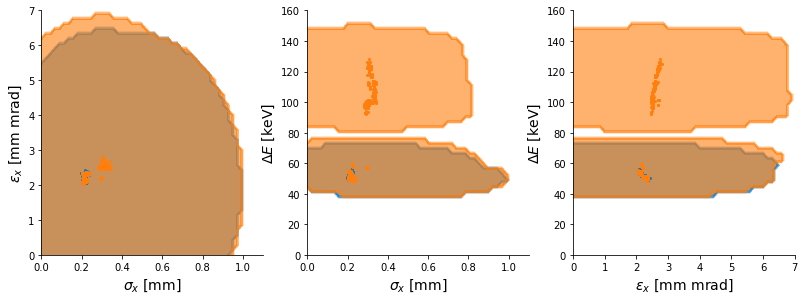

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(13.5, 4.5))

k = 0
for i, y_col in enumerate(objective_cols):
    for j, x_col in enumerate(objective_cols):
        if j >= i:
            continue

        ax = axes[k]

        df = opal_validation.query('`optim` == "forward_model"')
        dots = ax.plot(df[x_col],
                       df[y_col],
                       'o',
                       color=sns.color_palette()[0],
                       markersize=markersize)

        if i_gen > 0:
            # need the case distinction to avoid weird plotting artifacts...
            # is there a bug when dots don't fit into the limits of the plot?
            
            df = to_plot.query('`optim` == "random"')
            
            draw_confidence_intervals(df[x_col].values,
                                      df[y_col].values,
                                      [q],
                                      [residual_quantiles.query('`quantile` == @q')[x_col].values],
                                      [residual_quantiles.query('`quantile` == @q')[y_col].values],
                                      obj_limits[x_col],
                                      obj_limits[y_col],
                                      50,
                                      colormaps[0],
                                      ax)

        df = opal_validation.query('`optim` == "invertible_model"')
        dots = ax.plot(df[x_col],
                       df[y_col],
                       'o',
                       color=sns.color_palette()[1],
                       markersize=markersize)

        
        df = to_plot.query('`optim` == "invertible"')
        draw_confidence_intervals(df[x_col].values,
                                  df[y_col].values,
                                  [0.9],
                                  [residual_quantiles.query('`quantile` == 0.9')[x_col].values],
                                  [residual_quantiles.query('`quantile` == 0.9')[y_col].values],
                                  obj_limits[x_col],
                                  obj_limits[y_col],
                                  50,
                                  colormaps[1],
                                  ax)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        ax.set_xlabel(obj_labels[x_col], fontsize=14)
        ax.set_ylabel(obj_labels[y_col], fontsize=14)

        ax.tick_params(labelsize=10)

        ax.set_xlim(obj_limits[x_col])
        ax.set_ylim(obj_limits[y_col])

        k += 1

fig.savefig(f'{plot_dir}/optimal_configs_validation.jpg', dpi=dpi)

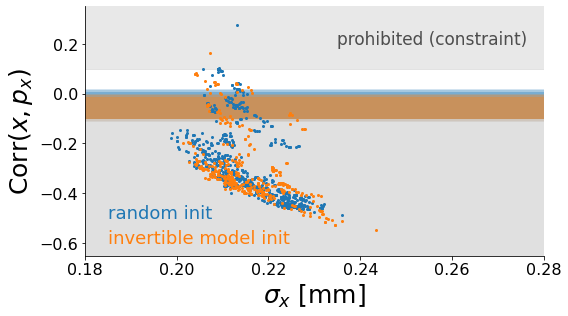

In [42]:
fig, ax = plt.subplots(figsize=(8, 4.5))

xlim = [0.18, 0.28]
ylim = [-0.65, 0.35]

for i, optim in enumerate(['forward_model', 'invertible_model']):
    df = opal_validation.query('`optim` == @optim')
    
    ax.plot(df['RMS Beamsize in x'],
            df['Correlation xpx'],
            'o',
            markersize=2,
            color=sns.color_palette()[i])
    
    df = objectives.query(f'(`generation` == 999) & (`optim` == "{labels[i]}")')
    
    draw_confidence_intervals(df['RMS Beamsize in x'].values,
                              df['Correlation xpx'].values,
                              [0.9],
                              [residual_quantiles.query('`quantile` == 0.9')['RMS Beamsize in x'].values],
                              [residual_quantiles.query('`quantile` == 0.9')['Correlation xpx'].values],
                              xlim,
                              ylim,
                              50,
                              colormaps[i],
                              ax)

ax.fill_between(x=[0, 0.3],
                y1=0.1,
                y2=1.,
                color='lightgray',
                alpha=0.5)
ax.fill_between(x=ax.get_xlim(),
                y1=-0.1,
                y2=-1.,
                color='lightgray',
                alpha=0.7)

ax.set_xlim(xlim)
ax.set_ylim(ylim)

ax.set_xlabel(r'$\sigma_x$ [mm]', fontsize=25)
ax.set_ylabel(r'$\mathrm{Corr}(x, p_x)$', fontsize=25)
ax.tick_params(labelsize=16)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.text(x=0.185,
        y=-0.5,
        s='random init',
        fontsize=18,
        color=sns.color_palette()[0])
ax.text(x=0.185,
        y=-0.6,
        s='invertible model init',
        fontsize=18,
        color=sns.color_palette()[1])

ax.text(x=0.235,
        y=0.2,
        s='prohibited (constraint)',
        fontsize=17,
        color=np.array([77, 77, 77]) / 255)

fig.tight_layout()
fig.savefig(f'{plot_dir}/correlation.jpg', dpi=dpi)